# <center> **CLIM 680 Assignment** </center>

```
The following notebook makes use of Soil Moisture Active Passive (SMAP) Level 4 (L4) data which consists of the assimilation of raw or corrected measurements into a land surface model to produce geophysical parameters. Data files from 20210627 are obtained from the Center for Ocean-Land-Atmosphere Studies' remote server, though they are publicly available through NASA-designated data centers. The file contains information pertaining to the heat flux, soil moisture, and surface state variables at the stated time. This dataset was chosen because it is relevant to my research.
```

## Table of Contents

---
* [Imports](#Imports)
* [Assignment One](#AOne)
    * [Data Info and Access](#DataAc1)
    * [Filled Contour](#Contour)
    * [Filled Contour Map](#Map)
* [Assignment Two](#ATwo)
    * [Multi-File Access](#DataAc2)
    * [Data Aggregation](#Groupby)
    * [Climatology](#Clim)
    
---

## Imports<a class="anchor" id="Imports"></a>

In [2]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import glob
import calendar
from datetime import datetime

In [2]:
#import sys
#!conda install -c conda-forge --yes --prefix {sys.prefix} h5netcdf

In [3]:
#xr.__version__

## Assignment One<a class="anchor" id="AOne"></a>

### Data Info & Access<a class="anchor" id="DataAc1"></a>

In [4]:
file = "/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_20210627.nc4"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                            (x: 3856, y: 1624)
Coordinates:
  * x                                  (x) float64 -1.736e+07 ... 1.736e+07
  * y                                  (y) float64 7.31e+06 ... -7.31e+06
Data variables:
    EASE2_global_projection            |S1 ...
    cell_column                        (y, x) float64 ...
    cell_lat                           (y, x) float32 ...
    cell_lon                           (y, x) float32 ...
    cell_row                           (y, x) float64 ...
    time                               datetime64[ns] ...
    baseflow_flux                      (y, x) float32 ...
    heat_flux_ground                   (y, x) float32 ...
    heat_flux_latent                   (y, x) float32 ...
    heat_flux_sensible                 (y, x) float32 ...
    height_lowatmmodlay                (y, x) float32 ...
    land_evapotranspiration_flux       (y, x) float32 ...
    land_fraction_saturated            (y, x) float32 ...
   

### Filled Contour<a class="anchor" id="Contour"></a>

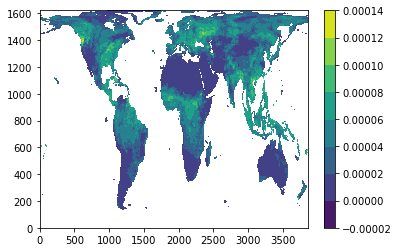

In [5]:
plt.contourf(ds["land_evapotranspiration_flux"][-1::-1,:]);
plt.colorbar()

### Filled Contour Map<a class="anchor" id="Map"></a>

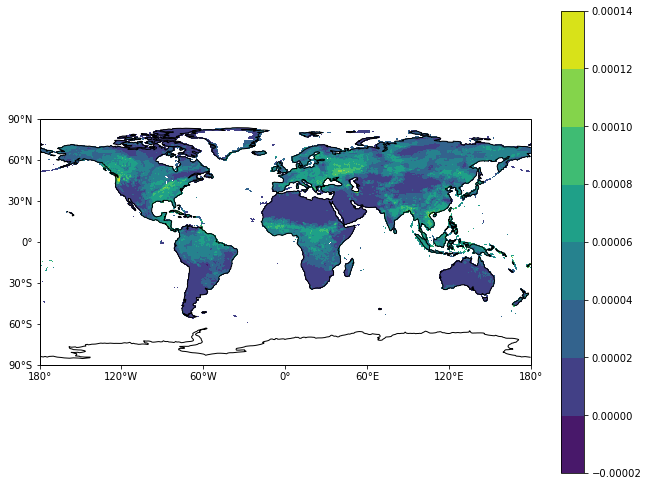

In [6]:
# Set size of image
fig = plt.figure(figsize=(11,8.5))

# Set the axes projection for plot
ax = plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
cs = ax.contourf(ds['cell_lon'], ds['cell_lat'], ds['land_evapotranspiration_flux'], transform = ccrs.PlateCarree())

# Add Coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

cbar = plt.colorbar(cs)

## Assignment Two<a class="anchor" id="ATwo"></a>

### Multi-File Access<a class="anchor" id="DataAc2"></a>

In [3]:
ds2_list = glob.glob("/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_201*.nc4")
#netcdf_list

In [4]:
ds2 = xr.open_mfdataset(paths=ds2_list, combine='nested', concat_dim='time').isel(y=slice(600,120, -1), 
                                                                                  x=slice(540,1280))
ds2

<xarray.Dataset>
Dimensions:                            (time: 1736, x: 740, y: 480)
Coordinates:
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * time                               (time) datetime64[ns] 2016-03-25T01:28:55.816000 ... 2019-08-29T01:28:55.816000
Data variables:
    EASE2_global_projection            (time) |S1 b'' b'' b'' ... b'' b'' b''
    cell_column                        (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (time, y, x) float32 dask.array<chunksize=(1, 48

### Data Aggregation<a class="anchor" id="Groupby"></a>

In [5]:
ds2_climo=ds2.groupby('time.month').mean(dim='time')
ds2_climo

<xarray.Dataset>
Dimensions:                            (month: 12, x: 740, y: 480)
Coordinates:
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * month                              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cell_column                        (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    heat_flux_ground                   (month, y, x) float32 dask.array<chunksize=(1, 4

### 12-Panel Climatology<a class="anchor" id="Clim"></a>

Text(0.5, 0.94, 'Monthly Climatology of Leaf Area Index (2015-2019) from SMAP L4')

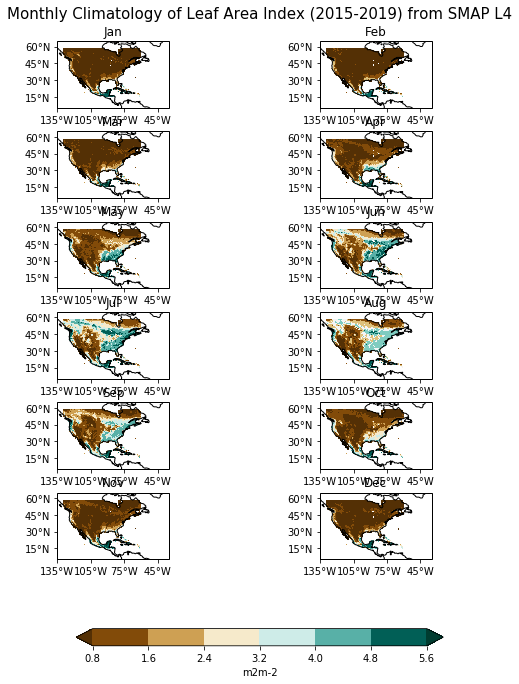

In [46]:
# Define the figure and each axis for the 6 rows and 2 columns
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(nrows=6,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["leaf_area_index"][i,:,:],
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-35,30), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.35)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m2m-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Leaf Area Index ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)